In [4]:
import os
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Get the GPU ready

In [6]:
import torch

In [7]:
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


# Import Libraries and Frameworks

In [8]:
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [9]:
import tarfile
from torch.utils.data import TensorDataset
from torchvision.datasets.utils import download_url

# Download the Data

In [10]:
flag = False # since the data has been downloaded and saved 

In [11]:
if flag:
    url = 'http://files.fast.ai/data/cifar10.tgz'
    download_url(url, '.')

In [12]:
if flag:
    with tarfile.open('cifar10.tgz') as  tar:
        tar.extractall()

# Preprocess the Data only once

In [13]:
# creating the key-value dictionary
name = {}
count = 0
for file in os.listdir('./cifar10/train'):
    name[file] = count
    count += 1
name

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [14]:
classes = {}
for val in name:
    classes[name[val]] = val
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [15]:
# training data
if flag:
    X_train = []
    y_train = []

    for file in os.listdir('./cifar10/train'):
        for image in tqdm(os.listdir('./cifar10/train/' + file)):
            try:
                path = './cifar10/train/' + file + '/' + image
                img = torch.tensor(plt.imread(path))
                label = name[file]
                X_train.append(img)
                y_train.append(label)
            except:
                pass

In [16]:
# testing data
if flag:
    X_test = []
    y_test = []

    for file in os.listdir('./cifar10/test'):
        for image in tqdm(os.listdir('./cifar10/test/' + file)):
            try:
                path = './cifar10/test/' + file + '/' + image
                img = torch.tensor(plt.imread(path))
                label = name[file]
                X_test.append(img)
                y_test.append(label)
            except:
                pass

In [17]:
if flag:
    for index, data in enumerate([X_train, y_train, X_test, y_test]):
        name = ''

        if index % 2 == 0:
            name += 'X_'
            data = torch.stack(data)
        else:
            name += 'y_'
            data = torch.tensor(data)

        if index < 2:
            name += 'train.pt'
        else:
            name += 'test.pt'

        torch.save(data, name)

# Load the Saved Data 

In [18]:
X_train = torch.load('X_train.pt').permute(0,3,1,2)
X_test = torch.load('X_test.pt').permute(0,3,1,2)
y_train = torch.load('y_train.pt')
y_test = torch.load('y_test.pt')

In [19]:
X_train[0].permute(1,2,0).shape

torch.Size([32, 32, 3])

In [20]:
print('Training Size:', len(y_train))
print('Testing Size:', len(y_test))

Training Size: 50000
Testing Size: 10000


In [21]:
def imread(img, label):
    print(classes[label.item()])
    plt.imshow(img.permute(1,2,0))

airplane


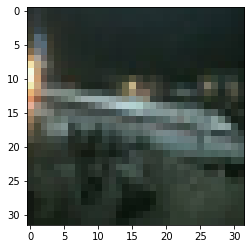

In [22]:
imread(X_test[0], y_test[0])

# Dividing Training Data into Batches

In [23]:
def split_indices(n, val_pct = 0.2, seed = 69):
    val = (int)(n * val_pct)
    np.random.seed(seed)
    perm = np.random.permutation(n)
    
    return perm[val:], perm[:val]

In [24]:
n = len(X_train)
train_ind, val_ind = split_indices(n)
print('Training Data:', len(train_ind))
print('Validation Data:', len(val_ind))

Training Data: 40000
Validation Data: 10000


In [25]:
batch_size = 128
data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

# training data
train_sample = SubsetRandomSampler(train_ind)
train_dl = DataLoader(data_train,
                      batch_size,
                      sampler = train_sample)

# validation data
val_sample = SubsetRandomSampler(val_ind)
val_dl = DataLoader(data_train,
                    batch_size,
                    sampler = val_sample)

# test data
test_dl = DataLoader(data_test, batch_size)

In [26]:
for x, y in train_dl:
    print(x.shape)
    break
    
for x, y in val_dl:
    print(x.shape)
    break
    
for x, y in test_dl:
    print(x.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


# Creating the Model

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [41]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(16, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3, padding  = 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

In [42]:
model.to(device)
optimiser = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

# Training and Testing Functions

In [31]:
def train(model, criterion, optimiser):
    model.train()
    avg_loss = 0
    
    for X_batch, y_batch in tqdm(train_dl):
        model.zero_grad()
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimiser.step()
        
        loss = loss.cpu().detach().numpy()
        avg_loss += loss.item()
        
        del X_batch, y_batch, pred, loss
        torch.cuda.empty_cache()
        
    avg_loss /= len(train_ind)
    return avg_loss

In [32]:
def evaluate(model, criterion):
    model.eval()
    avg_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dl):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            
            loss = loss.cpu().detach().numpy()
            avg_loss += loss.item()
            correct += torch.sum(torch.argmax(pred, axis = 1) == y_batch).item()
            
            del X_batch, y_batch, pred, loss
            torch.cuda.empty_cache()
            
    avg_loss /= len(val_ind)
    acc = correct / len(val_ind)
    del correct
    
    return avg_loss, acc

In [33]:
def fit(model, criterion, optimiser, epochs = 15):
    train_loss_rec = []
    val_loss_rec = []
    val_acc_rec = []
    max_acc = 0
    best_model = model
    
    for epoch in range(epochs):
        train_loss = train(model, criterion, optimiser)
        train_loss_rec.append(train_loss)
        
        val_loss, val_acc = evaluate(model, criterion)
        val_loss_rec.append(val_loss)
        val_acc_rec.append(val_acc)
        
        print(f"Train Loss: {train_loss}  Val Loss: {val_loss}  Val Acc: {val_acc}")
        
        if max_acc < val_acc:
            best_model = model
            max_acc = val_acc
            
    plt.plot(train_loss_rec)
    plt.plot(val_loss_rec)
    plt.show()
    
    plt.plot(val_acc_rec)
    plt.show()
    
    return max_acc, best_model

In [34]:
def test(model):
    correct = 0
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_dl):
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            correct += torch.sum(torch.argmax(pred, axis = 1) == y_batch).item()
            
            del X_batch, y_batch, pred
            torch.cuda.empty_cache()
            
    test_acc = correct / len(y_test)
    del correct
    
    return test_acc

<b>Sanity Check</b>: Evaluate the initial model on the validation set. The accuracy should be about 10%, the ideal for random predictions.

In [43]:
print(evaluate(model, criterion))


(0.018212801909446717, 0.1074)


# Training the Model

In [ ]:
best_acc, model = fit(model, criterion, optimiser)

In [ ]:
evaluate(model, criterion)

In [ ]:
best_acc, model = fit(model, criterion, optimiser, epochs = 10)

In [ ]:
optimiser2 = optim.Adam(model.parameters(), lr = 1e-4)
best_acc, model = fit(model, criterion, optimiser, epochs = 10)

# Testing the best Val Acc Model

In [ ]:
print(test(model))

In [ ]:
best_acc # validation acuracy

# Saving the Model

In [ ]:
torch.save(model.state_dict(), 'cifar10-CNN.pty')

# Loading the saved model

In [28]:
model2 = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(16, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3, padding  = 1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

In [29]:
criterion = nn.CrossEntropyLoss()
model2.load_state_dict(torch.load('cifar10-CNN.pty'))
model2.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten()
  (13): Linear(in_features=128, out_features=32, bias=True)
  (14): ReLU()
  (15): Linear(in_features=32, out_features=10, bias=True)
)

In [35]:
print('Evaluation Accuracy:', evaluate(model2, criterion)[1])


Evaluation Accuracy: 0.6981


In [36]:
print('Test Accuracy:', test(model2))


Test Accuracy: 0.6887
